<a href="https://colab.research.google.com/github/ysj9909/NLP_practice/blob/main/NMT(Attention).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NEURAL MACHINE TRANSLATION BY JOINTLY LEARNING TO ALIGN AND TRANSLATE (ICLR 2015) 코드 구현 연습


## 데이터 전처리
 * spacy Library를 이용해서 영어, 독일어 전처리 진행

In [1]:
%%capture
!python -m spacy download en
!python -m spacy download de

In [2]:
import spacy

spacy_en = spacy.load("en")   # 영어 토큰화
spacy_de = spacy.load("de")   # 독일어 토큰화

In [3]:
# 토크나이저 실습
text = "I'm eating instant noodles"

for i, word in enumerate([token.text for token in spacy_en.tokenizer(text)]):
  print(f"{i + 1} 번째 토큰은 {word}입니다.")

1 번째 토큰은 I입니다.
2 번째 토큰은 'm입니다.
3 번째 토큰은 eating입니다.
4 번째 토큰은 instant입니다.
5 번째 토큰은 noodles입니다.


In [4]:
# 토크나이저 함수 정의
def tokenize_en(text):
  # 영어 문장 스트링으로부터 단어 스트링들의 리스트로 변환
  return [token.text for token in spacy_en.tokenizer(text)]

def tokenize_de(text):
  # 독일어 문장 스트링으로부터 단어 스트링들의 리스트로 변환하고 성능 향상을 위해 순서를 반대로 바꿈
  return [token.text for token in spacy_de.tokenizer(text)][::-1]

In [5]:
# 독일어 - 영어 번역 데이터셋을 불러들인다
from torchtext.legacy.datasets import Multi30k
# Field를 통해 전처리 명명, 필요한 패드 수를 최소화할 수 있는 배치(Batch) Iterator를 불러온다
from torchtext.legacy.data import Field, BucketIterator

SRC = Field(tokenize = tokenize_de,
            init_token = "<sos>",
            eos_token = "<eos>",
            lower = True)
TRG = Field(tokenize = tokenize_en, 
            init_token = "<sos>",
            eos_token = "<eos>",
            lower = True)

train_dataset , valid_dataset, test_dataset = Multi30k.splits(exts = (".de", ".en"),
                                                              fields = (SRC, TRG))

In [6]:
# 데이터의 개수 확인
print(f"Number of training examples : {len(train_dataset.examples)}")
print(f"Number of validation examples : {len(valid_dataset.examples)}")
print(f"Number of test examples : {len(test_dataset.examples)}")

Number of training examples : 29000
Number of validation examples : 1014
Number of test examples : 1000


In [7]:
# 데이터의 타입 확인(src data가 순서가 뒤집어져 있는 것을 확인할 수 있다.)
print(vars(train_dataset.examples[0]))

{'src': ['.', 'büsche', 'vieler', 'nähe', 'der', 'in', 'freien', 'im', 'sind', 'männer', 'weiße', 'junge', 'zwei'], 'trg': ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']}


In [8]:
# Vocabulary 객체 생성
SRC.build_vocab(train_dataset, min_freq = 2)
TRG.build_vocab(train_dataset, min_freq = 2)

print(f"length of source Vocabulary : {len(SRC.vocab)}")
print(f"length of target Vocabulary : {len(TRG.vocab)}")

length of source Vocabulary : 7855
length of target Vocabulary : 5893


In [9]:
import torch
import torch.nn as nn
import numpy as np
import random
import math
import time

# device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [58]:
# Hyper-parameters
batch_size = 128
num_epochs = 10
learning_rate = 0.001
hidden_dim = 1000
embed_dim = 620
att_dim = 1000

In [11]:
# Iterator 생성
trainloader, validloader, testloader = BucketIterator.splits(datasets = (train_dataset, valid_dataset, test_dataset),
                                                             batch_size = batch_size,
                                                             device = device)

In [12]:
print(TRG.vocab["<sos>"])

2


In [23]:
# 배치(batch) 형태 확인
for batch in trainloader:
  print(batch.src.size())
  print(batch.trg.size())

  trg_text = batch.trg[:, 0]
  for i, token in enumerate(trg_text):
    print(f"index : {i}, token : {token}")
  break

torch.Size([32, 128])
torch.Size([31, 128])
index : 0, token : 2
index : 1, token : 33
index : 2, token : 6
index : 3, token : 256
index : 4, token : 162
index : 5, token : 5001
index : 6, token : 44
index : 7, token : 97
index : 8, token : 182
index : 9, token : 76
index : 10, token : 44
index : 11, token : 172
index : 12, token : 5
index : 13, token : 3
index : 14, token : 1
index : 15, token : 1
index : 16, token : 1
index : 17, token : 1
index : 18, token : 1
index : 19, token : 1
index : 20, token : 1
index : 21, token : 1
index : 22, token : 1
index : 23, token : 1
index : 24, token : 1
index : 25, token : 1
index : 26, token : 1
index : 27, token : 1
index : 28, token : 1
index : 29, token : 1
index : 30, token : 1


## 모델 정의

In [14]:
# LSTM을 사용
class Encoder(nn.Module):
  def __init__(self, vocab_size, embed_dim, hidden_dim, n_layers =2):
    super(Encoder, self).__init__()
    self.n_layers = n_layers
    self.hidden_dim = hidden_dim

    self.embedding = nn.Embedding(vocab_size, embed_dim)

    self.Bi_LSTM = nn.LSTM(embed_dim, hidden_dim, num_layers = n_layers, batch_first = True, bidirectional = True, dropout = 0.5)

  def forward(self, src):
    # src : source sentences , shape of (src_length, batch_size)
    src = src.permute(1, 0)   # (batch_size, src_length)
    emb = self.embedding(src)  # (batch_size, src_length, embed_dim)
    
    h0 = torch.zeros(2 * self.n_layers, src.size(0), self.hidden_dim).to(device)
    c0 = torch.zeros(2 * self.n_layers, src.size(0), self.hidden_dim).to(device)

    output, _ = self.Bi_LSTM(emb, (h0, c0))    # (batch_size, src_length, 2 * hidden_dim)

    return output

In [16]:
# 논문에서의 구조를 그대로 구현함(GRU 구현)
class Decoder(nn.Module):
  def __init__(self, vocab_size, embed_dim, hidden_dim, att_dim):
    super(Decoder, self).__init__()
    self.vocab_size = vocab_size
    self.embed_dim = embed_dim
    self.hidden_dim = hidden_dim
    
    self.embedding = nn.Embedding(vocab_size, embed_dim)

    self.W = nn.Linear(embed_dim, hidden_dim)
    self.U = nn.Linear(hidden_dim, hidden_dim)
    self.C = nn.Linear(2 * hidden_dim, hidden_dim)
    self.W_z = nn.Linear(embed_dim, hidden_dim)
    self.U_z = nn.Linear(hidden_dim, hidden_dim)
    self.C_z = nn.Linear(2 * hidden_dim, hidden_dim)
    self.W_r = nn.Linear(embed_dim, hidden_dim)
    self.U_r = nn.Linear(hidden_dim, hidden_dim)
    self.C_r = nn.Linear(2 * hidden_dim ,hidden_dim)

    self.W_s = nn.Linear(2 * hidden_dim, hidden_dim)

    self.W_a = nn.Linear(hidden_dim, att_dim)
    self.U_a = nn.Linear(2 * hidden_dim, att_dim)
    self.v_a = nn.Linear(att_dim, 1)

    self.U_o = nn.Linear(hidden_dim, hidden_dim)
    self.V_o = nn.Linear(embed_dim, hidden_dim)
    self.C_o = nn.Linear(2 * hidden_dim, hidden_dim)

    self.W_o = nn.Linear((hidden_dim // 2), vocab_size)

    self.max_out = nn.MaxPool1d(kernel_size = 2, stride = 2)   # for single  maxout hidden layer

  def forward(self, enc_hidden, trg, teacher_forcing_ratio = 0.5):
    """
    enc_hidden : encoder's hidden states , shape of (batch_size, src_length, 2 * hidden_dim)
    trg : target sentences, shape of (max_seq_length, batch_size)
    """
    max_seq_length = trg.size(0)
    batch_size = enc_hidden.size(0)
    src_length = enc_hidden.size(1)
    attentions = torch.zeros(max_seq_length, batch_size, src_length)
    outputs = torch.zeros(max_seq_length, batch_size, self.vocab_size).to(device)
    
    s_prev = torch.tanh(self.W_s(enc_hidden[:, -1, :]))   # (batch_size, hidden_dim)
    y_prev = self.embedding(trg[0])   # (batch_size, embed_dim)
    for i in range(1, max_seq_length):
      att = torch.tanh(self.W_a(s_prev).unsqueeze(1).repeat(1, src_length, 1) + self.U_a(enc_hidden))   # (batch_size, src_length, att_dim)
      energy = self.v_a(att).squeeze(-1)   # (batch_size, src_length)
      attention_weights = (torch.exp(energy) / torch.sum(torch.exp(energy), dim = -1, keepdim = True)).unsqueeze(1)   # (batch_size, 1, src_length)
      c = torch.bmm(attention_weights, enc_hidden).squeeze(1)   # (batch_size, 2 * hidden_dim)
      z = torch.sigmoid(self.W_z(y_prev) + self.U_z(s_prev) + self.C_z(c))
      r = torch.sigmoid(self.W_r(y_prev) + self.U_r(s_prev) + self.C_r(c))
      s_ = torch.tanh(self.W(y_prev) + self.U(r * s_prev) + self.C(c))

      s = (1 - z) * s_prev + z * s_   # (batch_size, hidden_dim)

      out = self.U_o(s_prev) + self.V_o(y_prev) + self.C_o(c)
      out = self.max_out(out)   # (batch_size, hidden_dim / 2)
      out = self.W_o(out)   # (batch_size, vocab_size)
      _, output = torch.max(out, dim = -1)
      outputs[i] = out
      attentions[i] = attention_weights.squeeze(1)

      s_prev = s
      # when we train the model, use ground-truth with probability of teacher_forcing_ratio
      y_prev = self.embedding(output) if random.random() < teacher_forcing_ratio else self.embedding(trg[i])
    
    return outputs, attentions


In [59]:
encoder = Encoder(len(SRC.vocab), embed_dim, hidden_dim).to(device)
decoder = Decoder(len(TRG.vocab), embed_dim, hidden_dim, att_dim).to(device)

**모델 학습**

In [60]:
# 논문의 내용대로 정규분포로 초기화
def init_weights(model):
  for name, param in model.named_parameters():
    nn.init.normal_(param.data, mean = 0, std = 0.001)

encoder.apply(init_weights) 
decoder.apply(init_weights)

Decoder(
  (embedding): Embedding(5893, 620)
  (W): Linear(in_features=620, out_features=1000, bias=True)
  (U): Linear(in_features=1000, out_features=1000, bias=True)
  (C): Linear(in_features=2000, out_features=1000, bias=True)
  (W_z): Linear(in_features=620, out_features=1000, bias=True)
  (U_z): Linear(in_features=1000, out_features=1000, bias=True)
  (C_z): Linear(in_features=2000, out_features=1000, bias=True)
  (W_r): Linear(in_features=620, out_features=1000, bias=True)
  (U_r): Linear(in_features=1000, out_features=1000, bias=True)
  (C_r): Linear(in_features=2000, out_features=1000, bias=True)
  (W_s): Linear(in_features=2000, out_features=1000, bias=True)
  (W_a): Linear(in_features=1000, out_features=1000, bias=True)
  (U_a): Linear(in_features=2000, out_features=1000, bias=True)
  (v_a): Linear(in_features=1000, out_features=1, bias=True)
  (U_o): Linear(in_features=1000, out_features=1000, bias=True)
  (V_o): Linear(in_features=620, out_features=1000, bias=True)
  (C_o):

In [61]:
# Loss and optimizer
PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)
params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = torch.optim.Adam(params, lr = learning_rate)

In [62]:
# For checking training time for one epoch
def cal_epoch_time(start_time, end_time):
  int_time = end_time - start_time
  mins = int(int_time / 60)
  secs = int(int_time - (mins * 60))
  return mins, secs

In [63]:
clip = 1
best_valid_loss = float('inf')

for epoch in range(num_epochs):
  start_time = time.time()   # 시작 시간 기록
  for i, batch in enumerate(trainloader):
    src = batch.src.to(device)
    trg = batch.trg.to(device)
    
    enc_hidden = encoder(src)
    outputs, attentions = decoder(enc_hidden, trg)
    
    # <sos> 토큰은 학습에 사용하지 않음
    voc_size = outputs.size(-1)
    outputs = outputs[1:].view(-1, voc_size)
    trg = trg[1:].view(-1)

    optimizer.zero_grad()

    loss = criterion(outputs, trg)
    loss.backward()

    # gradient clipping
    torch.nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    torch.nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    optimizer.step()

    if (i + 1) % 100 == 0:
      print(f"Epoch [{epoch + 1} / {num_epochs}], Step [{i + 1} / {len(trainloader)}], Loss : {loss.item():.3f}, PPL : {math.exp(loss.item()):.3f}")
    if loss < best_valid_loss:
      best_valid_loss = loss
      torch.save(encoder.state_dict(), "Attention_NMT_enc.ckpt")
      torch.save(decoder.state_dict(), "Attention_NMT_dec.ckpt")
  end_time= time.time() # 종료 시간 기록
  mins, secs = cal_epoch_time(start_time, end_time)
  print(f"Epoch [{epoch + 1} / {num_epochs}] | Time : {mins}m {secs}s")



Epoch [1 / 10], Step [100 / 227], Loss : 4.700, PPL : 109.898
Epoch [1 / 10], Step [200 / 227], Loss : 4.518, PPL : 91.646
Epoch [1 / 10] | Time : 2m 47s
Epoch [2 / 10], Step [100 / 227], Loss : 3.856, PPL : 47.269
Epoch [2 / 10], Step [200 / 227], Loss : 3.655, PPL : 38.681
Epoch [2 / 10] | Time : 2m 11s
Epoch [3 / 10], Step [100 / 227], Loss : 3.478, PPL : 32.387
Epoch [3 / 10], Step [200 / 227], Loss : 3.057, PPL : 21.259
Epoch [3 / 10] | Time : 2m 5s
Epoch [4 / 10], Step [100 / 227], Loss : 2.865, PPL : 17.551
Epoch [4 / 10], Step [200 / 227], Loss : 2.984, PPL : 19.773
Epoch [4 / 10] | Time : 2m 5s
Epoch [5 / 10], Step [100 / 227], Loss : 2.594, PPL : 13.383
Epoch [5 / 10], Step [200 / 227], Loss : 2.537, PPL : 12.642
Epoch [5 / 10] | Time : 2m 3s
Epoch [6 / 10], Step [100 / 227], Loss : 2.394, PPL : 10.960
Epoch [6 / 10], Step [200 / 227], Loss : 2.039, PPL : 7.680
Epoch [6 / 10] | Time : 2m 1s
Epoch [7 / 10], Step [100 / 227], Loss : 2.083, PPL : 8.027
Epoch [7 / 10], Step [200 

In [ ]:
# 학습된 모델 저장
from google.colab import files

files.download("Attention_NMT_dec.ckpt")
files.download("Attention_NMT_enc.ckpt")

In [66]:
# Train the model
encoder.eval()
decoder.eval()
epoch_loss = 0
with torch.no_grad():
  for batch in testloader:
    src = batch.src.to(device)
    trg = batch.trg.to(device)

    enc_hidden = encoder(src)
    outputs, attentions = decoder(enc_hidden, trg)

    voc_size = outputs.size(-1)
    outputs = outputs[1:].view(-1, voc_size)
    trg = trg[1:].view(-1)

    loss = criterion(outputs, trg)
    epoch_loss += loss

loss = epoch_loss / len(testloader)
print(f"Test Loss : {loss:.3f}, Test PPL : {math.exp(loss):.3f}")

Test Loss : 2.465, Test PPL : 11.765


**모델 실제로 사용**

In [69]:
import numpy as np
import matplotlib.pyplot as plt

def translate_attention(src, trg):
  src_list = [SRC.vocab.itos[word] for word in src]
  src_sentence = " ".join(src_list)
  print(f"소스 문장 : {src_sentence}")
  
  trg_list = [TRG.vocab.itos[word] for word in trg]
  trg_sentence = " ".join(trg_list)
  print(f"타겟 문장 : {trg_sentence}")
  
  encoder.eval()
  decoder.eval()

  with torch.no_grad():
    enc_hidden = encoder(src)
    outputs, attentions = decoder(enc_hidden, trg)

  _, out = torch.max(outputs, dim = -1)
  translated_sentence = " ".join([TRG.vocab.itos[word] for word in out])
  print(f"번역된 문장 : {translated_sentence}")

  # ---------------------------------
  # for visualizing attention weights
  attentions = attentions.squeeze(1).numpy()
  attentions = attentions[:len(trg_list), :len(src_list)]


  fig, ax = plt.subplots()
  im = ax.imshow(attentions)

  # Show all ticks and label them with the respective list entries
  ax.set_xticks(np.arange(len(trg_list)), trg_list)
  ax.set_yticks(np.arange(len(src_list)), src_list) 

  # Rotate the tick labels and set their alignment
  plt.setp(ax.get_xticklabels(), rotation = 45, ha = "right", rotation_mode = "anchor")

  ax.set_title("Attention Map")
  fig.tight_layout()
  plt.show()


소스 문장 : <sos> . hinab häuser viele auf blicken frauen zwei <eos> <pad>
타겟 문장 : <sos> two women look out at many houses below . <eos> <pad> <pad>
번역된 문장 : <unk> two women are on at many houses . . <eos> <eos> .


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


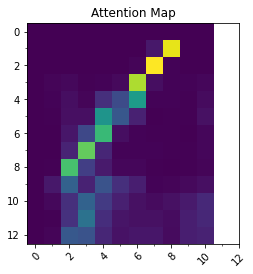

In [70]:
idx = 24

for batch in validloader:
  src = batch.src[:, idx].unsqueeze(-1)
  trg = batch.trg[:, idx].unsqueeze(-1)
  break

translate_attention(src, trg)